In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import tri, cm
import meshio
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

Definições Geométricas

In [2]:
msh = meshio.read('./mesh/new_cube.msh')

X = msh.points[:,0]
Y = msh.points[:,1]
Z = msh.points[:,2]

In [3]:
dt = 1e-3
Nt = 1_000
T = np.arange(0, Nt*dt, dt)

beta = 0.5

In [4]:
IEN = np.array([])
IENBound = np.array([])

for cellBlock in msh.cells:
    if cellBlock.type == 'triangle':
        if IENBound.shape == (0,):
            IENBound = cellBlock.data
        else:
            IENBound = np.concatenate([IENBound, cellBlock.data])
    elif cellBlock.type == 'tetra':
        if IEN.shape == (0,):
            IEN = cellBlock.data
        else:
            IEN = np.concatenate([IEN, cellBlock.data])

In [5]:
Npoints = len(X)
ne = IEN.shape[0]

In [35]:
# IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
# boundNames = list(msh.field_data.keys())
# IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]
# npoints = len(X)
# ne = IEN.shape[0]

In [ ]:
# # cria lista de nos do contorno
# cc = np.unique(IENbound.reshape(IENbound.size))
# ccName = [[] for i in range( len(X) )]
# for elem in range(0,len(IENbound)):
#  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
#  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
#  ccName[ IENbound[elem][2] ] = IENboundElem[elem]
# # plot malha e pontos de contorno (export para vtk)
# meshio.write_points_cells('malha.vtk',
#  msh.points,
#  msh.cells,)

In [6]:
cc = np.unique(IENBound.reshape(IENBound.size))
meshio.write_points_cells('./mesh/new_cube.vtk',
 msh.points,
 msh.cells,)

Definições do material

In [7]:
# Boundary conditions
Tcc = lambda x, y, z, t: (x*x + y*y + z*z)*(np.exp(t) - 1)

In [8]:
rho = 1
cv = 1
alpha = 1

kappa = [1, 1, 1] # kx, ky, kz

Q = lambda x, y, z, t: ((x*x + y*y + z*z)*np.exp(t) -6*alpha*(np.exp(t) - 1))*rho*cv

In [9]:
#form functions for 2D
def IENfunc3DTet(K, M, IEN):
    for IENelem in IEN:
        tet_matrix = np.array([[1, X[IENelem[i]], Y[IENelem[i]] , Z[IENelem[i]]] for i in range(4)])
        tet_volume = np.linalg.det(tet_matrix)/6

        melem = (tet_volume/20)*np.array(([2, 1, 1, 1],
                                          [1, 2, 1, 1],
                                          [1, 1, 2, 1],
                                          [1, 1, 1, 2]))
        
        [a_list, b_list, c_list, d_list] = np.linalg.inv(tet_matrix)
        
        kxelem = kappa[0]*tet_volume*np.array([[b_list[i]*b_list[j] for i in range(4)] for j in range(4)])
        kyelem = kappa[1]*tet_volume*np.array([[c_list[i]*c_list[j] for i in range(4)] for j in range(4)])
        kzelem = kappa[2]*tet_volume*np.array([[d_list[i]*d_list[j] for i in range(4)] for j in range(4)])

        kelem = kxelem + kyelem + kzelem

        for ilocal in range(4):
            iglobal = IENelem[ilocal]

            for jlocal in range(4):
                jglobal = IENelem[jlocal]

                K[iglobal,jglobal] += kelem[ilocal,jlocal]
                M[iglobal,jglobal] += melem[ilocal,jlocal]

In [10]:
K  = np.zeros((Npoints, Npoints), dtype = float) 
M  = np.zeros((Npoints, Npoints), dtype = float)

IENfunc3DTet(K, M, IEN)

In [11]:
T_vec = np.zeros((Nt, Npoints))

In [12]:
T_vec[0] = [Tcc(X[i], Y[i], Z[i], 0) for i in range(Npoints)]

In [13]:
A  = M/dt + beta*K
A2 = M/dt - (1 - beta)*K

A1inv = np.linalg.inv(A)

In [14]:
for i in range(1, Nt):
    t = i*dt

    b = A2@T_vec[i - 1]

    for j in cc:
        b[j] = Tcc(X[j], Y[j], Z[j], t)
    
    T_vec[i] = A1inv@b

In [15]:
expected_T = [[Tcc(X[i], Y[i], Z[i], T[j]) for i in range(Npoints)] for j in range(Nt)]

In [16]:
error = abs(expected_T - T_vec)

In [17]:
error_MSE = [np.sqrt(sum(elem**2)/Npoints) for elem in error]

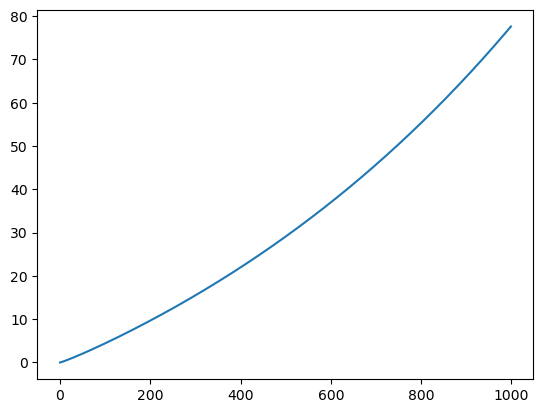

In [18]:
plt.plot(error_MSE)
plt.show()

In [ ]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")


f3, ax5 = plt.subplots(1,1)
sns.heatmap(flights, square=True, norm=LogNorm())

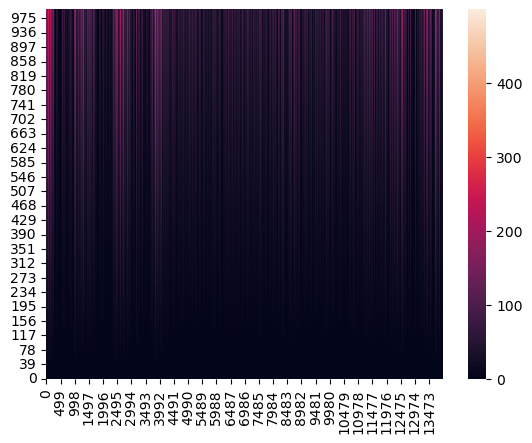

In [23]:
ax = sns.heatmap(error)
ax.invert_yaxis()
plt.show()